In [28]:
# Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv("dataset\Sleep_data__nonorm_ML2568.csv")
print("Loaded dataset shape:", df.shape)

Loaded dataset shape: (11470, 143)


In [29]:
# SLOT 2: Cleaning & Preprocessing

target_col = 'f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:allday'

# # drop col with no norm in its name and print the dropped names
# cols_to_drop = [col for col in df.columns if 'norm' not in col]
# df = df.drop(columns=cols_to_drop)
# print("Dataset shape after dropping non-norm columns:", df.shape)
# print("Dropped columns:", cols_to_drop)

# drop col 0, date_, f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain_norm:allday
df = df.drop(df.columns[0], axis=1)
df = df.drop(columns=['date_'], errors='ignore')
df = df.drop(columns=['f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain_norm:allday'], errors='ignore')

# move date and pid cols for later use
later_use_cols = df[['date', 'pid']].copy()
df = df.drop(columns=['date', 'pid'], errors='ignore')

# convert pid to numeric with one hot encoding
later_use_cols['pid_num'] = later_use_cols['pid'].str.extract('(\d+)').astype(int)
later_use_cols = later_use_cols.drop(columns=['pid'], errors='ignore')

# convert date into separate date columns
later_use_cols['date'] = pd.to_datetime(later_use_cols['date'], errors='coerce')
later_use_cols['day'] = later_use_cols['date'].dt.day
later_use_cols['month'] = later_use_cols['date'].dt.month
later_use_cols['year'] = later_use_cols['date'].dt.year
later_use_cols = later_use_cols.drop(columns=['date'], errors='ignore')
later_use_cols = later_use_cols.drop(columns=['year'], errors='ignore') # year are all the same

# # use cyclic encoding for month and day
# later_use_cols['day_sin'] = np.sin(2 * np.pi * later_use_cols['day'] / 31)
# later_use_cols['day_cos'] = np.cos(2 * np.pi * later_use_cols['day'] / 31)
# later_use_cols = later_use_cols.drop(columns=['day'], errors='ignore')

# later_use_cols['month_sin'] = np.sin(2 * np.pi * later_use_cols['month'] / 12)
# later_use_cols['month_cos'] = np.cos(2 * np.pi * later_use_cols['month'] / 12)
# later_use_cols = later_use_cols.drop(columns=['month'], errors='ignore')

print("Later use cols shape:", later_use_cols.shape)
later_use_cols.head()

Later use cols shape: (11470, 3)


,pid_num,day,month
0,1,3,4
1,1,4,4
2,1,5,4
3,1,6,4
4,1,7,4


In [30]:

# df = df.drop(columns=['pid', 'date', 'date_'], errors='ignore')  # drop non-informative columns
# print("After dropping non-informative cols shape:", df.shape)

# add later_use_cols back to df
df = pd.concat([df, later_use_cols], axis=1)
print("After adding later_use_cols shape:", df.shape)

# drop rows with missing col val > 70%
row_missing_ratio = df.isna().mean(axis=1)
df = df.loc[row_missing_ratio <= 0.7]
print("After dropping high-missing rows shape:", df.shape)

# 2.1 ดรอปคอลัมน์ที่ missing > 70%
missing_ratio = df.isnull().sum() / len(df)
df = df.loc[:, missing_ratio <= 0.7]
print("After dropping high-missing cols shape:", df.shape)

# replace missing values with MI (Mutual Information)
from sklearn.feature_selection import mutual_info_regression

df_with_target = df.dropna(subset=[target_col]).copy()
df_without_target = df[df[target_col].isna()].copy()
print(f"Dataset shape: {df.shape}")
print(f"Rows with target: {len(df_with_target)} size: {df_with_target.shape}")
print(f"Rows without target: {len(df_without_target)} size: {df_without_target.shape}")

# Count rows that have at least 70% non-missing values
rows_with_enough_data = df_with_target[df_with_target.notna().mean(axis=1) >= 0.7]
print("Rows with at least 70% non-missing values:", rows_with_enough_data.shape[0])
# Use rows_with_enough_data to compute fill values. median because it's robust to outliers
fill_values = rows_with_enough_data.median(numeric_only=True)
# Fill missing values in df_with_target using those values
df_with_target = df_with_target.fillna(fill_values)

print("After filling missing values shape:", df_with_target.shape)

# Calculate Mutual Information scores
mi_scores = mutual_info_regression(
    df_with_target.drop(columns=[target_col]),
    df_with_target[target_col],
    discrete_features='auto',
    random_state=42
)
mi_series = pd.Series(mi_scores, index=df_with_target.drop(columns=[target_col]).columns)
mi_series = mi_series.sort_values(ascending=False)
print("Mutual Information scores:\n", mi_series)

# drop features with MI score of 0 except month_sin, month_cos, day_sin, day_cos, pid_num
zero_mi_cols = mi_series[mi_series == 0].index.tolist()
keep_cols = ["month_sin", "month_cos", "day_sin", "day_cos", "pid_num"]
zero_mi_cols = [col for col in zero_mi_cols if col not in keep_cols]
df_with_target = df_with_target.drop(columns=zero_mi_cols)
print("After dropping zero-MI cols shape:", df_with_target.shape)

After adding later_use_cols shape: (11470, 141)
After dropping high-missing rows shape: (9896, 141)
After dropping high-missing cols shape: (9896, 91)
Dataset shape: (9896, 91)
Rows with target: 6455 size: (6455, 91)
Rows without target: 3441 size: (3441, 91)
Rows with at least 70% non-missing values: 6010
After filling missing values shape: (6455, 91)
Mutual Information scores:
 pid_num                                                                 0.101476
f_slp:fitbit_sleep_summary_rapids_avgefficiencymain:allday              0.076654
f_screen:phone_screen_rapids_sumdurationunlock_locmap_home:night        0.021893
f_slp:fitbit_sleep_summary_rapids_avgefficiencymain_norm:allday         0.021370
f_steps:fitbit_steps_intraday_rapids_countepisodeactivebout:allday      0.020191
                                                                          ...   
f_steps:fitbit_steps_intraday_rapids_sumdurationactivebout:afternoon    0.000000
f_steps:fitbit_steps_intraday_rapids_sumsteps:morn

In [31]:
# drop target col from features

X = df_with_target.drop(columns=[target_col], errors='ignore')
y = df_with_target[target_col]

print("X shape:", X.shape)
print("y shape:", y.shape)

# print col name in x
print("Example feature columns:", X.columns)


X shape: (6455, 68)
y shape: (6455,)
Example feature columns: Index(['f_slp:fitbit_sleep_summary_rapids_avgefficiencymain:allday',
       'f_slp:fitbit_sleep_summary_rapids_avgefficiencymain_norm:allday',
       'f_blue:phone_bluetooth_doryab_uniquedevicesall:afternoon',
       'f_blue:phone_bluetooth_doryab_uniquedevicesall:evening',
       'f_blue:phone_bluetooth_doryab_uniquedevicesall:morning',
       'f_blue:phone_bluetooth_doryab_uniquedevicesall:night',
       'f_call:phone_calls_rapids_incoming_count:allday',
       'f_call:phone_calls_rapids_outgoing_count:allday',
       'f_call:phone_calls_rapids_outgoing_sumduration:allday',
       'f_loc:phone_locations_doryab_movingtostaticratio:afternoon',
       'f_loc:phone_locations_doryab_timeathome:afternoon',
       'f_loc:phone_locations_locmap_duration_in_locmap_study:afternoon',
       'f_loc:phone_locations_locmap_duration_in_locmap_exercise:afternoon',
       'f_loc:phone_locations_locmap_duration_in_locmap_greens:afternoon',


In [32]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


In [33]:
def train_evaluate_model(model, X, y, model_name="Model", n_splits=5, scale=False, plot_last_fold=True):
    """
    Train and evaluate a regression model using K-Fold CV.

    Parameters:
        model: sklearn-like or XGBoost model with .fit() and .predict()
        X: pandas DataFrame or numpy array of features
        y: pandas Series or numpy array of target
        model_name: string, name of the model for display
        n_splits: int, number of K-Folds
        scale: bool, whether to standardize features (recommended for MLP/Linear models)
        plot_last_fold: bool, whether to plot predictions of the last fold
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    mae_list, rmse_list, r2_list = [], [], []

    # Print model's input size
    if hasattr(X, "shape"):
        print(f"{model_name} input feature size: {X.shape}")
    else:
        print(f"{model_name} input feature size: {X.shape}")  # for numpy arrays

    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        # Properly select rows for pandas or numpy
        if hasattr(X, "iloc"):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        else:
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
    
        # Optionally scale
        if scale:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled  = scaler.transform(X_test)
        else:
            X_train_scaled = X_train.values if hasattr(X_train, "values") else X_train
            X_test_scaled  = X_test.values if hasattr(X_test, "values") else X_test
    
        # Train model
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        # Evaluate
        mae  = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2   = r2_score(y_test, y_pred)

        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)

        print(f"{model_name} — Fold {fold} | MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

    # Print average metrics
    print(f"\n{model_name} — Average across {n_splits} folds:")
    print(f"MAE  : {np.mean(mae_list):.4f}")
    print(f"RMSE : {np.mean(rmse_list):.4f}")
    print(f"R²   : {np.mean(r2_list):.4f}")

    # Plot last fold
    if plot_last_fold:
        plt.figure(figsize=(6,6))
        plt.scatter(y_test, y_pred, alpha=0.5, color='darkorange')
        plt.xlabel("Actual Sleep Duration (normalized)")
        plt.ylabel("Predicted Sleep Duration (normalized)")
        plt.title(f"{model_name} — Predicted vs Actual (Last Fold)")

        low, high = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
        plt.plot([low, high], [low, high], 'r--')
        plt.show()
    
    return np.mean(mae_list), np.mean(rmse_list), np.mean(r2_list)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best MLP params: {'activation': 'tanh', 'hidden_layer_sizes': (256, 128), 'learning_rate_init': 0.001}
MLP Regressor (Best) input feature size: (6455, 68)
MLP Regressor (Best) — Fold 1 | MAE: 110.8589, RMSE: 144.9748, R²: -0.6438
MLP Regressor (Best) — Fold 2 | MAE: 111.1386, RMSE: 143.8091, R²: -0.6417
MLP Regressor (Best) — Fold 3 | MAE: 112.9154, RMSE: 148.8652, R²: -0.7868
MLP Regressor (Best) — Fold 4 | MAE: 113.1616, RMSE: 149.8709, R²: -0.7087
MLP Regressor (Best) — Fold 5 | MAE: 109.9966, RMSE: 142.2390, R²: -0.6859

MLP Regressor (Best) — Average across 5 folds:
MAE  : 111.6142
RMSE : 145.9518
R²   : -0.6934


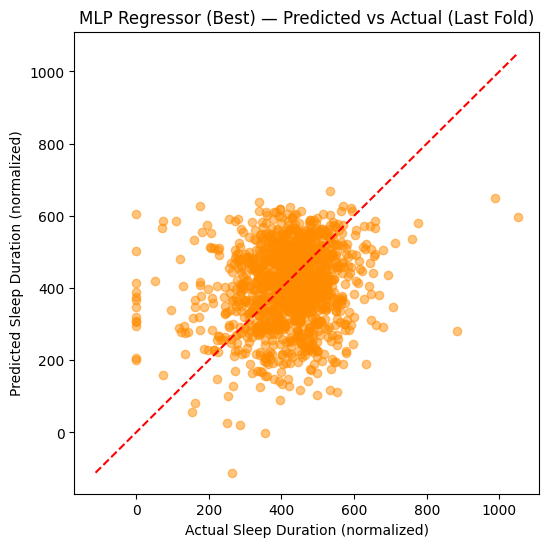

In [34]:
from sklearn.neural_network import MLPRegressor

mlp_param_grid = {
    'hidden_layer_sizes': [(256, 128), (512, 256, 128)],
    'learning_rate_init': [0.001, 0.0001],
    'activation': ['relu', 'tanh']
}

grid_mlp = GridSearchCV(
    MLPRegressor(max_iter=10000, random_state=42),
    mlp_param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)
grid_mlp.fit(X, y)
print("Best MLP params:", grid_mlp.best_params_)

mlp_best = grid_mlp.best_estimator_
mlp_metrics = train_evaluate_model(mlp_best, X, y, model_name="MLP Regressor (Best)", n_splits=5, scale=True)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best XGB params: {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 10, 'n_estimators': 800, 'subsample': 0.8}
XGBoost (Best) input feature size: (6455, 68)
XGBoost (Best) — Fold 1 | MAE: 76.9433, RMSE: 105.7466, R²: 0.1254
XGBoost (Best) — Fold 2 | MAE: 75.4849, RMSE: 102.0963, R²: 0.1726
XGBoost (Best) — Fold 3 | MAE: 74.8775, RMSE: 101.8290, R²: 0.1639
XGBoost (Best) — Fold 4 | MAE: 75.0466, RMSE: 104.9519, R²: 0.1621
XGBoost (Best) — Fold 5 | MAE: 74.5497, RMSE: 102.1056, R²: 0.1313

XGBoost (Best) — Average across 5 folds:
MAE  : 75.3804
RMSE : 103.3459
R²   : 0.1511


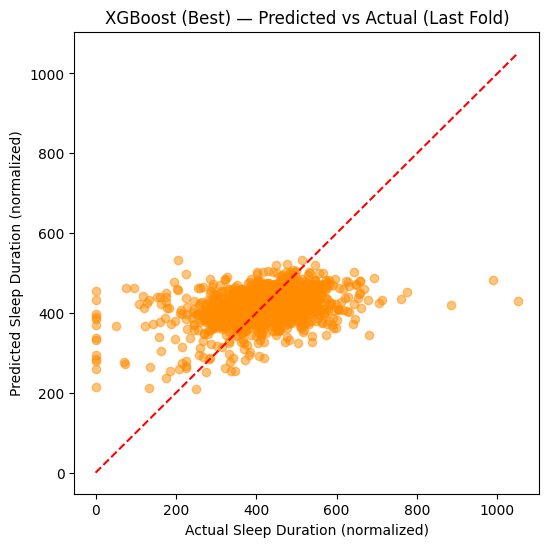

In [36]:
from xgboost import XGBRegressor

xgb_param_grid = {
    'n_estimators': [800, 1500],
    'learning_rate': [0.05, 0.03],
    'max_depth': [6, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_xgb = GridSearchCV(
    XGBRegressor(
        reg_lambda=1.0,
        reg_alpha=0.3,
        random_state=42,
        tree_method='hist'
    ),
    xgb_param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)
grid_xgb.fit(X, y)
print("Best XGB params:", grid_xgb.best_params_)

xgb_best = grid_xgb.best_estimator_
xgb_metrics = train_evaluate_model(xgb_best, X, y, model_name="XGBoost (Best)", n_splits=5, scale=True)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Tree params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Decision Tree (Best) input feature size: (6455, 68)
Decision Tree (Best) — Fold 1 | MAE: 80.4624, RMSE: 109.4683, R²: 0.0628
Decision Tree (Best) — Fold 2 | MAE: 79.5889, RMSE: 107.8161, R²: 0.0772
Decision Tree (Best) — Fold 3 | MAE: 80.0781, RMSE: 110.2638, R²: 0.0197
Decision Tree (Best) — Fold 4 | MAE: 78.6132, RMSE: 110.9059, R²: 0.0643
Decision Tree (Best) — Fold 5 | MAE: 79.4461, RMSE: 108.5415, R²: 0.0183

Decision Tree (Best) — Average across 5 folds:
MAE  : 79.6377
RMSE : 109.3991
R²   : 0.0485


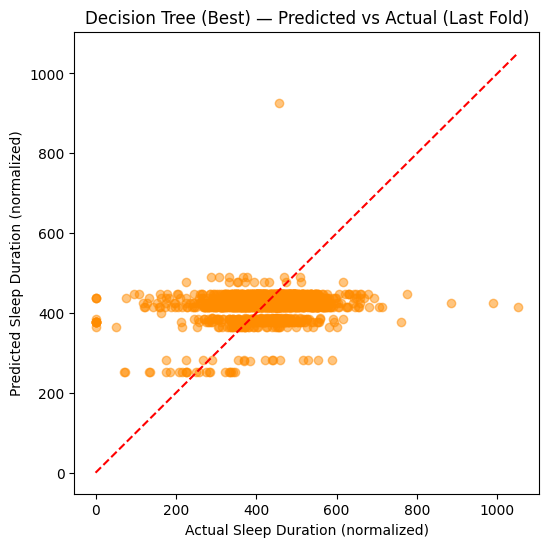

In [37]:
from sklearn.tree import DecisionTreeRegressor

tree_param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

grid_tree = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    tree_param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)
grid_tree.fit(X, y)
print("Best Tree params:", grid_tree.best_params_)

tree_best = grid_tree.best_estimator_
tree_metrics = train_evaluate_model(tree_best, X, y, model_name="Decision Tree (Best)", n_splits=5, scale=True)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Linear params: {'copy_X': True, 'fit_intercept': True}
Linear Regression (Best) input feature size: (6455, 68)
Linear Regression (Best) — Fold 1 | MAE: 79.2888, RMSE: 109.8781, R²: 0.0558
Linear Regression (Best) — Fold 2 | MAE: 78.6558, RMSE: 107.8863, R²: 0.0760
Linear Regression (Best) — Fold 3 | MAE: 78.9060, RMSE: 109.2148, R²: 0.0383
Linear Regression (Best) — Fold 4 | MAE: 77.7429, RMSE: 109.8422, R²: 0.0822
Linear Regression (Best) — Fold 5 | MAE: 76.7161, RMSE: 106.2586, R²: 0.0592

Linear Regression (Best) — Average across 5 folds:
MAE  : 78.2619
RMSE : 108.6160
R²   : 0.0623


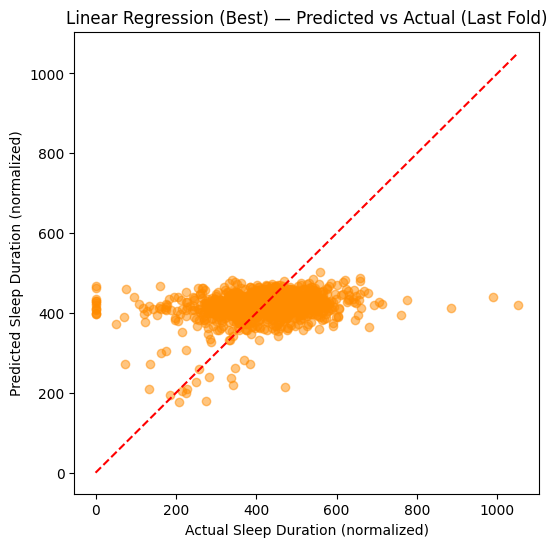

In [38]:
from sklearn.linear_model import LinearRegression

lin_param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}

grid_lin = GridSearchCV(
    LinearRegression(),
    lin_param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)
grid_lin.fit(X, y)
print("Best Linear params:", grid_lin.best_params_)

lin_best = grid_lin.best_estimator_
lin_metrics = train_evaluate_model(lin_best, X, y, model_name="Linear Regression (Best)", n_splits=5, scale=True)


In [39]:
# SLOT 17: Compare All Models
results = pd.DataFrame({
    "Model": ["MLP Regressor", "XGBoost", "Decision Tree", "Linear Regression"],
    "MAE": [mlp_metrics[0], xgb_metrics[0], tree_metrics[0], lin_metrics[0]],
    "RMSE": [mlp_metrics[1], xgb_metrics[1], tree_metrics[1], lin_metrics[1]],
    "R²": [mlp_metrics[2], xgb_metrics[2], tree_metrics[2], lin_metrics[2]],
})

results = results.sort_values(by='R²', ascending=False)
print(results)


               Model         MAE        RMSE        R²
1            XGBoost   75.380397  103.345872  0.151053
3  Linear Regression   78.261921  108.615988  0.062277
2      Decision Tree   79.637729  109.399143  0.048465
0      MLP Regressor  111.614239  145.951812 -0.693372


In [41]:
# save all models
import joblib
joblib.dump(mlp_best, "model_mlp.pkl")
joblib.dump(xgb_best, "model_xgb.pkl")
joblib.dump(tree_best, "model_tree.pkl")
joblib.dump(lin_best, "model_lin.pkl")

['model_lin.pkl']

In [43]:
# print x shape and col name
print("X shape:", X.shape)
print("Example feature columns:", X.columns)

X shape: (6455, 68)
Example feature columns: Index(['f_slp:fitbit_sleep_summary_rapids_avgefficiencymain:allday',
       'f_slp:fitbit_sleep_summary_rapids_avgefficiencymain_norm:allday',
       'f_blue:phone_bluetooth_doryab_uniquedevicesall:afternoon',
       'f_blue:phone_bluetooth_doryab_uniquedevicesall:evening',
       'f_blue:phone_bluetooth_doryab_uniquedevicesall:morning',
       'f_blue:phone_bluetooth_doryab_uniquedevicesall:night',
       'f_call:phone_calls_rapids_incoming_count:allday',
       'f_call:phone_calls_rapids_outgoing_count:allday',
       'f_call:phone_calls_rapids_outgoing_sumduration:allday',
       'f_loc:phone_locations_doryab_movingtostaticratio:afternoon',
       'f_loc:phone_locations_doryab_timeathome:afternoon',
       'f_loc:phone_locations_locmap_duration_in_locmap_study:afternoon',
       'f_loc:phone_locations_locmap_duration_in_locmap_exercise:afternoon',
       'f_loc:phone_locations_locmap_duration_in_locmap_greens:afternoon',
       'f_loc:pho